In [40]:
import numpy as np
import matplotlib.pyplot as plt
import simulationHawkes as sh

%matplotlib inline
optimalParams = []
epsilon = 1e-8
Dict_inf={}
Dict_con={}
Dict_integrate={}
Dict_gradient={}
dictdimP={}
mapping={}


def createMapAtoBIndex(a,b):
    start=time.time()
    mapAtoBIndex={}
    p1=0
    for x in range(len(a)):
        y=a[x]
        p=max(0,x)
        b1=b[p1:]
        if(max(b1[b1<y],default=-1)==-1):
            mapAtoBIndex[y] = None
        else:
            p1= p1+(np.where(b1==max(b1[b1<y])))[0][0]
            mapAtoBIndex[y] = p1 

    return mapAtoBIndex




  

## plots
def plotKernels(p):
    showIntegratedKernel = True
    dx=0.01
    
    tk = np.arange(0,5,dx)
    interestX = Dict[p]['inflection']
    
    y1 = alpha*np.exp(-beta*tk).reshape(-1)
    y2 = nnKernel(tk.reshape(1,-1),p).reshape(-1)
    y3 = (alpha/beta)*(1 - np.exp(-beta*tk)).reshape(-1)
    y4= np.cumsum(y2*dx).reshape(-1)
    y5 = nnIntegratedKernel(tk.reshape(1,-1),p).reshape(-1)
    
    plt.plot(tk.reshape(-1), y1,'tab:blue')
    plt.plot(tk.reshape(-1),y2,'tab:orange')
    #
    if(showIntegratedKernel):
        plt.plot(tk.reshape(-1), y3,'tab:green')
        plt.plot(tk.reshape(-1),y4,'tab:red')
        plt.plot(tk.reshape(-1),y5,'tab:brown')

    plt.grid()
    plt.pause(0.005)

def plotKernelsAll():

    dx=0.01
    tk = np.arange(0,5,dx)
    y1 = np.zeros([len(tk),totalD,totalD])
    y2 = np.zeros([len(tk),totalD,totalD])
    fig, ax = plt.subplots(totalD, totalD,sharex=True,sharey=True)
    
    for p in range(totalD):
        for k in range(totalD):
            alpha1=alpha[p,k]
            beta1=beta[p,k]
            delta1=delta[p,k]
            y1[:,p,k] = alpha1*(delta1+tk)**(-beta1)    
            ax[p][k].plot(tk.reshape(-1), y1[:,p,k],'tab:blue')
            y2[:,p,k] = nnKernel(tk.reshape(1,-1),p,k)
            ax[p][k].plot(tk.reshape(-1),y2[:,p,k],'tab:orange')
            ax[p][k].set_title(r"$\phi_{%g,%g}(t)$" %(p,k))
            #ax[p][k].set_ylim(y2[0,p,k],y2[,p,k])
            ax[p][k].grid()
    
    plt.tight_layout()
    plt.pause(0.005)
    return
## Code for Neural Hawkes starts here##


def inflectionPoints():
    Dict_inf.clear()
    Dict_con.clear()
    for p in range(totalD):
        for k in range(totalD):
            alphas = Alphas[:,p,k]
    
            betas = Betas[:,p,k]
            beta0 = Beta0[:,p,k]
    
            div = betas+epsilon*(np.abs(betas)<epsilon) # potentially error prone
            x = -beta0/div
            interestX1 = x*(x>0)
            alwaysInclude = (x<=0)*(betas>0) #dont change
            alwaysExclude = (x<=0)*(betas<0)
            tempX = x*(~alwaysInclude)*(~alwaysExclude)
            interestX1 = tempX[interestX1>0]
            interestX = np.sort(interestX1)
            interestX = np.append(0,interestX)
        
            Dict_inf[p,k]= interestX
   
            con = alphas*betas
            Dict_con[p,k] = con
    return


def nnIntegratedKernel(x,p,k):
    x = x.reshape(-1)
    alphas = Alphas[:,p,k].reshape(-1,1)
    alpha0 = Alpha0[:,p,k].reshape(-1,1)
    betas = Betas[:,p,k].reshape(-1,1)
    beta0 = Beta0[:,p,k].reshape(-1,1)
    const1 = Dict_con[p,k]
    interestX = Dict_inf[p,k]
    precalculate_integrate(p,k)
    
    y = np.zeros([1,max(x.shape)])
    
    for i in range(0,max(x.shape)):
        xi = x[i]
        if(xi>0):
            iP = max(interestX[interestX<xi])
            n1 = betas*(xi-epsilon) + beta0
            dn1 = (n1>0)
            const =np.dot(const1.T,dn1)
            
            
            term1 = nnKernel(xi,p,k)*((const!=0)+xi*(const==0))
            term2 = nnKernel(iP,p,k)*((const!=0)+iP*(const==0))
            
            const = (const)*(const!=0)+(const==0)*1.0
            
            prev_term = Dict_integrate[p,k][iP]
            
            y[0,i] = prev_term + ((term1-term2)/(const))
        
       
               

    return y


def nnKernel(x,p,k):
    alphas = Alphas[:,p,k].reshape(-1,1)
    alpha0 = Alpha0[:,p,k]
    betas = Betas[:,p,k].reshape(-1,1)
    beta0 = Beta0[:,p,k].reshape(-1,1)
    n1 = np.maximum(np.dot(betas,x) + beta0,0.)
    y = np.dot(alphas.T,n1) + alpha0
    
    y = np.exp(y)
    return y   



def initializeParams(nNeurons):
    
    
    for p in range(totalD):
        for k in range(totalD):
            Alphas[:,p,k] = -(np.random.uniform(0,1,nNeurons)).reshape(-1)*0.5
            Alpha0[:,p,k] = -np.random.uniform(0,1,1)*0.5
            Betas[:,p,k] = (np.random.uniform(0,1,nNeurons)).reshape(-1)*0.5
            Beta0[:,p,k] = np.random.uniform(0,1,nNeurons).reshape(-1)*0.05
            
        mu1[p] = len(t[p])/t[p][-1]*0.5
    return mu1


def precalculate_integrate(p,k):
    alphas = Alphas[:,p,k].reshape(-1,1)
    alpha0 = Alpha0[:,p,k].reshape(-1,1)
    betas = Betas[:,p,k].reshape(-1,1)
    beta0 = Beta0[:,p,k].reshape(-1,1)
    iP = Dict_inf[p,k]
    const1 = Dict_con[p,k]
    Dict_integrate[p,k].clear()
    Dict_integrate[p,k][0]=0
    y = 0
    for index in range(1,len(iP)):
        n1 = betas*(iP[index]-epsilon) + beta0
        dn1 = (n1>0)
        const =np.dot(const1.T,dn1)
            
            
        term1 = nnKernel(iP[index],p,k)*((const!=0)+iP[index]*(const==0))
        term2 = nnKernel(iP[index-1],p,k)*((const!=0)+iP[index-1]*(const==0))
            
        const = (const)*(const!=0)+(const==0)*1.0
              
        y= y + ((term1-term2)/(const))
        Dict_integrate[p,k][iP[index]]=y
    return


    
def precalculate_gradient(p,k):
    alphas = Alphas[:,p,k].reshape(-1,1)
    alpha0 = Alpha0[:,p,k].reshape(-1,1)
    betas = Betas[:,p,k].reshape(-1,1)
    beta0 = Beta0[:,p,k].reshape(-1,1)
    gradA = alphas*0
    gradB1 = gradA*0
    gradB0 = gradB1*0
    gradA0=0
    iP = Dict_inf[p,k]
    
    const1 = Dict_con[p,k]
    Dict_gradient[p,k].clear()
    Dict_gradient[p,k][0]=list([gradA0,gradA,gradB1,gradB0])
    for index in range(1,len(iP)):
            
            n0pr = betas*(iP[index-1]+epsilon)+beta0
            n1pr = betas*(iP[index]-epsilon) + beta0
            dn1 = (n1pr>0)
            dn0 = (n0pr>0)
            const =np.dot(const1.T,dn1)
            indicator = const==0
            const = const*(const!=0)+1*(const==0)
            n0 = betas*(iP[index-1])+beta0
            n1 = betas*(iP[index]) + beta0
            
            fac1 = nnKernel(iP[index],p,k)
            fac2 = nnKernel(iP[index-1],p,k)
            gradA0 = gradA0 + ((1/const)*(fac1-fac2))*(~indicator)+(fac1)*(indicator)*(iP[index]-iP[index-1])
            gradA = gradA -((1/(const*const))*(betas*dn1)*(fac1-fac2))*(~indicator)
            gradA = gradA + ((1/const)*(fac1*np.maximum(n1,0)-fac2*np.maximum(n0,0)))*(~indicator)
            gradB1 = gradB1 -((1/(const*const))*(alphas*dn1)*(fac1-fac2))*(~indicator)
            gradB1 = gradB1 + ((1/const)*(alphas)*(fac1*iP[index]*dn1-fac2*iP[index-1]*dn0))*(~indicator)
            gradB0 = gradB0+ ((1/const)*((alphas)*(fac1*dn1-fac2*dn0)))*(~indicator)
            Dict_gradient[p,k][iP[index]]= list([gradA0,gradA,gradB1,gradB0])
            
    return


def gradientNNIntegratedKernel(tend,p,k):
    
    alphas = Alphas[:,p,k].reshape(-1,1)
    alpha0 = Alpha0[:,p,k].reshape(-1,1)
    betas = Betas[:,p,k].reshape(-1,1)
    beta0 = Beta0[:,p,k].reshape(-1,1)
    
    gradA = alphas*0
    gradB1 = gradA*0
    gradB0 = gradB1*0
    gradA0=0
    
    if(tend>0):
        const1 = Dict_con[p,k]
        interestX = Dict_inf[p,k]
            
        iP = max(interestX[interestX<tend])
        n1pr = betas*(tend-epsilon) + beta0
        n0pr = betas*(tend+epsilon)+beta0
           
        dn1 = (n1pr>0)
        dn0 = (n0pr>0)
        const =np.dot(const1.T,dn1)
        indicator = const==0
        const = const*(const!=0)+1*(const==0)
        n0 = betas*(iP)+beta0
        n1 = betas*(tend) + beta0
        fac1 = nnKernel(tend,p,k)
        fac2 = nnKernel(iP,p,k)
        gradients = Dict_gradient[p,k][iP]
            
            
        gradA0 = gradA0+gradients[0] + ((1/const)*(fac1-fac2))*(~indicator)+(fac1)*(indicator)*(tend-iP)
            
        gradA = gradA + gradients[1] -((1/(const*const))*(betas*dn1)*(fac1-fac2))*(~indicator)
        gradA = gradA + ((1/const)*(fac1*np.maximum(n1,0)-fac2*np.maximum(n0,0)))*(~indicator)
            
        gradB1 = gradB1+gradients[2] -((1/(const*const))*(alphas*dn1)*(fac1-fac2))*(~indicator)
        gradB1 = gradB1+ ((1/const)*(alphas)*(fac1*tend*dn1-fac2*iP*dn0))*(~indicator)
    
        gradB0 =gradB0+ gradients[3] + ((1/const)*((alphas)*(fac1*dn1-fac2*dn0)))*(~indicator)
    return list([gradA0,gradA,gradB1,gradB0])




    
def gradientNNKernel(temp,p,k):
    alphas = Alphas[:,p,k].reshape(-1,1)
    alpha0 = Alpha0[:,p,k]
    betas = Betas[:,p,k].reshape(-1,1)
    beta0 = Beta0[:,p,k].reshape(-1,1)
    
    gradA = alphas*0
    gradB1 = gradA*0
    gradB0 = gradB1*0
    gradA0=0
    fac1 = nnKernel(temp.reshape(1,-1),p,k)
    
    n1 = np.dot(betas,temp.reshape(1,-1)) + beta0
    gradA = gradA + np.sum(fac1*np.maximum(n1,0),axis=1).reshape(-1,1)
        
    gradA0 = gradA0 + np.sum(fac1)
        
    gradB1 = gradB1 + np.sum(fac1*(n1>0)*alphas*temp.reshape(1,-1),axis=1).reshape(-1,1)
    gradB0 = gradB0 + np.sum(fac1*(n1>0)*alphas,axis=1).reshape(-1,1)
    return list([gradA0,gradA,gradB1,gradB0])    




     
def gradientNetwork(iArray):
    nNeurons=len(Alphas[:,0,0])
    gradA0 = np.zeros([1,totalD,totalD])
    gradA = np.zeros([nNeurons,totalD,totalD])
    gradB1 = np.zeros([nNeurons,totalD,totalD])
    gradB0 = np.zeros([nNeurons,totalD,totalD])
    grad_mu = np.zeros(totalD)
    nSamples = max(iArray.shape)
    
    for p in range(totalD):
        for k in range(totalD):
            precalculate_gradient(p,k)
    
    for i in range(0,nSamples,1):
        p = int(iArray[0,i])
        index = int(iArray[1,i])
        
        if index>0:
            
            for k in range(totalD):
                tend=t[p][-1]-t[p][index]

                if (tend>=0):
                    out = gradientNNIntegratedKernel(tend,k,p)
                    gradA0[:,k,p]=gradA0[:,k,p]+out[0]
                    gradA[:,k,p]=gradA[:,k,p]+out[1].reshape(-1)
                    gradB1[:,k,p]=gradB1[:,k,p]+out[2].reshape(-1)
                    gradB0[:,k,p]=gradB0[:,k,p]+out[3].reshape(-1)
                    
            decayFactor=0
            temp=[[] for j in range(totalD)]
            for k in range(totalD):
                if p==k:
                    li = max(index-20,0)
                    temp1 = t[p][index]-t[p][li:index]
                    temp[p] = temp1
                else:
                    jT = mapping[p,k].get(t[p][index])
                    if(jT != None):
                        j = (jT)
                        lj = max(j-20,0)
                        temp1 = t[p][index]-t[k][lj:j+1]
                        temp[k]=temp1
                decayFactor += np.sum(nnKernel(temp1.reshape(1,-1),p,k))
                lam = mu1[p]+decayFactor
                invLam = (1/lam)
    
            for k in range(totalD):
                out =  gradientNNKernel(temp[k],p,k)
        
                gradA0[:,p,k]=gradA0[:,p,k] -invLam*out[0]
                gradA[:,p,k]=gradA[:,p,k] -invLam*out[1].reshape(-1)
                gradB1[:,p,k]=gradB1[:,p,k]-invLam*out[2].reshape(-1)
                gradB0[:,p,k]=gradB0[:,p,k] -invLam*out[3].reshape(-1)
        

            grad_mu[p]=grad_mu[p]+((t[p][index]-t[p][index-1])-(1/lam))*(index >0) 
        
    gradA0 = gradA0/(nSamples)
    gradA = gradA/nSamples
    gradB1 = gradB1/nSamples
    gradB0 = gradB0/nSamples
    grad_mu =grad_mu/nSamples
        
    return list([gradA0,gradA,gradB1,gradB0,grad_mu])
     



def nnLoglikelihood():
    ll=0
    integrated=0
    for p in range(0,totalD,1):
        tend = (t[p][-1]-t[p][:])
        a = np.sum(nnIntegratedKernel(tend.reshape(1,-1),p,p))
        
        for k in dictdimP[p]:
            tend=(t[p][-1]-t[k][:])
            tend=tend*(tend>=0)
            a+=np.sum(nnIntegratedKernel(tend.reshape(1,-1),p,k))
        
        ll = ll+ mu1[p]*t[p][-1]+a
        integrated+=ll
       
        ll = ll-np.log(mu1[p])
        
        tp=t[p]
        for i in range(1,len(tp),1):
            li = max(i-20,0)
            temp1 = tp[i]-tp[li:i]
            decayFactor = np.sum(nnKernel(temp1.reshape(1,-1),p,p))
            for k in dictdimP[p]:
                jT = mapping[p,k].get(tp[i])
                if(jT != None):
                    j =(jT).item()
                    lj = max(j-20,0)
                    temp1 = tp[i]-t[k][lj:j+1]
                decayFactor+= np.sum(nnKernel(temp1.reshape(1,-1),p,k))
            logLam = -np.log(mu1[p]+decayFactor)
            
            ll = ll+logLam
    print("integrated Kernel",integrated)
       
    return ll


def sgdNeuralHawkesBiVariate(nNeurons,nEpochs,lr,t):
    
    global Alpha0
    global Alphas
    global Betas
    global Beta0
    global mu1
    global totalD
    global tmax
    totalD=len(t)
    Alphas = np.zeros([nNeurons,totalD,totalD])
    Alpha0 = np.zeros([1,totalD,totalD])
    Betas = np.zeros([nNeurons,totalD,totalD])
    Beta0 = np.zeros([nNeurons,totalD,totalD])
    mu1 = np.zeros(totalD)
    initializeParams(nNeurons)
    for j in range(totalD):
        if t[j][0]!=0:
            t[j]=np.insert(t[j],0,0)

    for p in range(totalD):
        for k in range(totalD):
            Dict_integrate[p,k] = {}  #nested dictionary for all networks
            Dict_gradient[p,k] = {}






    

    
    lr2 =lr*0.5
    lr_mu = lr*0.1
    
    beta_1 = 0.9
    beta_2 =0.999
  
    
    bestll = 1e8
    neg_ll = []
    
    optimalParams = list([Alpha0,Alphas,Betas,Beta0])
    
    m_t_A = np.zeros([nNeurons,totalD,totalD])
    m_t_A0 =np.zeros([1,totalD,totalD])
    m_t_B= np.zeros([nNeurons,totalD,totalD])
    m_t_B0= np.zeros([nNeurons,totalD,totalD])
    m_t = np.zeros(totalD)
    v_t_A = np.zeros([nNeurons,totalD,totalD])
    v_t_A0 =np.zeros([1,totalD,totalD])
    v_t_B= np.zeros([nNeurons,totalD,totalD])
    v_t_B0= np.zeros([nNeurons,totalD,totalD])
    v_t = np.zeros(totalD)
    count = 0
    totalLength=0
    for j in range(len(t)):
        totalLength+=len(t[j])
    tCompressed=np.zeros((2,totalLength))
    length=0
    for j in range(len(t)):
        length1=length
        length+=len(t[j])
        tCompressed[0,length1:length]=j
        tCompressed[1,length1:length]=np.arange(0,length-length1,1)
    print(totalLength,"number of timepoints")
    
    for epochs in range(1,nEpochs+1,1):
        inflectionPoints()
        rsample = np.random.choice(totalLength,totalLength,replace = False)
        for i in range(0,len(rsample),50):
            count=count+1 
            grad = gradientNetwork(tCompressed[:,rsample[i:i+50]])
            
            m_t = beta_1*m_t + (1-beta_1)*grad[4]	#updates the moving averages of the gradient
            v_t = beta_2*v_t + (1-beta_2)*(grad[4]*grad[4])	#updates the moving averages of the squared gradient
            m_cap = m_t/(1-(beta_1**count))		#calculates the bias-corrected estimates
            v_cap = v_t/(1-(beta_2**count))		#calculates the bias-corrected estimates
            mu1 = mu1-(lr_mu*m_cap)/(np.sqrt(v_cap)+epsilon)
            mu1 = np.maximum(mu1,1e-5)
           
           
            m_t_A0 = beta_1*m_t_A0 + (1-beta_1)*grad[0]	#updates the moving averages of the gradient
            v_t_A0 = beta_2*v_t_A0 + (1-beta_2)*(grad[0]*grad[0])	#updates the moving averages of the squared gradient
            m_cap_A0 = m_t_A0/(1-(beta_1**count))		#calculates the bias-corrected estimates
            v_cap_A0 = v_t_A0/(1-(beta_2**count))		#calculates the bias-corrected estimates
            Alpha0 = Alpha0-(lr*m_cap_A0)/(np.sqrt(v_cap_A0)+epsilon) 
                         
                   
            m_t_A = beta_1*m_t_A + (1-beta_1)*grad[1]	#updates the moving averages of the gradient
            v_t_A = beta_2*v_t_A + (1-beta_2)*(grad[1]*grad[1])	#updates the moving averages of the squared gradient
            m_cap_A = m_t_A/(1-(beta_1**count))		#calculates the bias-corrected estimates
            v_cap_A = v_t_A/(1-(beta_2**count))		#calculates the bias-corrected estimates
            Alphas = Alphas-(lr*m_cap_A)/(np.sqrt(v_cap_A)+epsilon)
            
            

            
                
            m_t_B = beta_1*m_t_B + (1-beta_1)*grad[2]	#updates the moving averages of the gradient
            v_t_B = beta_2*v_t_B + (1-beta_2)*(grad[2]*grad[2])	#updates the moving averages of the squared gradient
            m_cap_B = m_t_B/(1-(beta_1**count))		#calculates the bias-corrected estimates
            v_cap_B= v_t_B/(1-(beta_2**count))		#calculates the bias-corrected estimates
            Betas = Betas-(lr2*m_cap_B)/(np.sqrt(v_cap_B)+epsilon)
            
            
            m_t_B0 = beta_1*m_t_B0 + (1-beta_1)*grad[3]	#updates the moving averages of the gradient
            v_t_B0 = beta_2*v_t_B0 + (1-beta_2)*(grad[3]*grad[3])	#updates the moving averages of the squared gradient
            m_cap_B0 = m_t_B0/(1-(beta_1**count))		#calculates the bias-corrected estimates
            v_cap_B0 = v_t_B0/(1-(beta_2**count))		#calculates the bias-corrected estimates
            Beta0 = Beta0 -(lr2*m_cap_B0)/(np.sqrt(v_cap_B0)+epsilon)
          
            inflectionPoints()
            
        error=nnLoglikelihood()
        neg_ll.append(error)
            #bestpara = para*(bestll>=error)+bestpara*(bestll<error)
            
        if(bestll > error):
            optimalParams = list([Alpha0,Alphas,Betas,Beta0,mu1])
                
               
            
        bestll = min(bestll,error)
        print(i,epochs,bestll,error,mu1)   #iteration, -loglikelihood, bestloglik, currentpara, bestpara
        
        
    return optimalParams,neg_ll,bestll
            
            




In [42]:


def powerLawIntegratedKernel(tend,p,k):
    alpha1 = alpha[p,k]
    beta1 = beta[p,k]
    delta1 = delta[p,k]
    ll =  - (alpha1 /(1 - beta1)) * delta1**(1 - beta1)
    ll2 = (alpha1 /(1 - beta1)) * (delta1 + tend) ** (1 - beta1)
    res = ll + ll2
    # res = (alpha1/beta1)*(1-np.exp(-beta1*tend))
    return res


def powerLawKernel(tp,p,k):
    alpha1 = alpha[p,k]
    beta1 = beta[p,k]
    delta1 = delta[p,k]

    res = alpha1*(delta1 + tp)**(-beta1)
    return res


def loglikelihood():
    ll=0
    integrated=0
    for p in range(0,totalD,1):
        tend = (tmax-t[p][:])
        a = np.sum(powerLawIntegratedKernel(tend.reshape(1,-1),p,p))
        for k in dictdimP[p]:
            tend=(tmax-t[k][:])
            a+=np.sum(powerLawIntegratedKernel(tend.reshape(1,-1),p,k))
        a+=mu[p]*tmax
        integrated+=a
        ll = ll+a
        ll = ll-np.log(mu[p])
        tp = t[p][:]  
        for i in range(1,len(tp),1):
            li = max(i-20,0)
            temp1 = tp[i]-tp[li:i]
            decayFactor = np.sum(powerLawKernel(temp1.reshape(1,-1),p,p))
            for k in dictdimP[p]:
                jT = mapping[p,k].get(tp[i])
                if(jT != None):
                    j = jT
                    lj = max(j-20,0)
                    temp2 = tp[i]-t[k][lj:j+1]
                    decayFactor = decayFactor + np.sum(powerLawKernel(temp2.reshape(1,-1),p,k))
            logLam = -np.log(mu[p]+decayFactor)
            ll = ll+logLam
    # print("Integrated Kernel",integrated)
    return ll


n_nodes=2
#alpha=np.ones([n_nodes,n_nodes])*0.2
#alpha[0,0]=1.2
#alpha[0,1]=0.0


#alpha[1,0]=1.2
#alpha[1,1]=0.42
#alphaSGD[3,2]=alpha[3,1]=alpha[2,3]=0
#beta=np.ones([n_nodes,n_nodes])*3
#beta[0,0]=4
#beta[0,1]=1
#beta[1,0]=2
#beta[1,1]=2
#mu=np.ones(n_nodes)*0.2
#mu[0]=0.12
#mu[1]=0.07
#T=5000
#t=multiSimHawkes(alpha,beta,mu,T)
    
#types=[['exp','rect'],['neg','exp']]
#kernels=[[[0.2,3],[0.7,0.3,1]],[[0.2,3],[0.2,3]]]
#mu=[0.3,0.2]
#runtime=2000

#t=sh.multiSimHawkesAll(mu,runtime,types,kernels)
#types=[['exp','exp'],['exp','exp']]
#kernels=[[[0.2,3],[0,3],[0.2,0.8]],[[0.2,3],[0.1,3],[0.3,0.7,1]],[[0.2,1],[0,3],[0.4,3]]]
#mu=[0.2,0.1,0.3]
#runtime=3000
#t=sh.multiSimHawkesAll(mu,runtime,types,kernels)
#----------------------------------------PowerLaw-----------------------------------------#

#from tick.hawkes import SimuHawkes, HawkesKernelPowerLaw

#exponent = 4
#cutoff = 1
#multiplier = np.array([1, 0.1, 0.6, 0.21])
#beta=np.ones((n_nodes,n_nodes))*exponent
#delta=np.ones((n_nodes,n_nodes))*cutoff
#alpha=multiplier.reshape(n_nodes,n_nodes)
#support = 3000
#mu=[0.05,0.05]
#hawkes = SimuHawkes(
#    kernels=[[
#        HawkesKernelPowerLaw(multiplier[0], cutoff, exponent, support),
#        HawkesKernelPowerLaw(multiplier[1], cutoff, exponent, support)
#    ], [
#        HawkesKernelPowerLaw(multiplier[2], cutoff, exponent, support),
#        HawkesKernelPowerLaw(multiplier[3], cutoff, exponent, support)
#    ]], baseline=mu, seed=382, verbose=False)
#hawkes.end_time = 50000
#hawkes.simulate()
##
##
#t = hawkes.timestamps
##=-------------------------randomKernbel-----------------------------------#




from tick.hawkes import (SimuHawkes, HawkesKernelTimeFunc, HawkesKernel0)
from tick.base import TimeFunction

run_time = 60000

t_values1 = np.array([0, 1, 1.5, 2., 3.5], dtype=float)
y_values1 = np.array([0, 0.2, 0, 0.1, 0.], dtype=float)
tf1 = TimeFunction([t_values1, y_values1],
                   inter_mode=TimeFunction.InterConstRight, dt=0.1)
kernel1 = HawkesKernelTimeFunc(tf1)

t_values2 = np.linspace(0, 4, 20)
y_values2 = np.maximum(0., np.sin(t_values2) / 4)
tf2 = TimeFunction([t_values2, y_values2])
kernel2 = HawkesKernelTimeFunc(tf2)

kernel3 = HawkesKernelTimeFunc(
    t_values=np.array([0., .7, 2.5, 3., 4.]),
    y_values=np.array([.3, .03, .03, .2, 0.]))

baseline = np.array([0.05, 0.05])

hawkes = SimuHawkes(baseline=baseline, end_time=run_time, verbose=False,
                    seed=2334)

hawkes.set_kernel(0, 0, kernel1)
hawkes.set_kernel(0, 1, kernel2)
hawkes.set_kernel(1, 0, HawkesKernel0())
hawkes.set_kernel(1, 1, kernel3)

hawkes.simulate()

t = hawkes.timestamps

totalD=len(t)
for j in range(totalD):
    if t[j][0]!=0:
        t[j]=np.insert(t[j],0,0)
    else:
        t[j]=np.array(t[j])

        
dimensions=np.arange(0,totalD,1)
for i in range(totalD):
    dictdimP[i]=np.delete(dimensions,i)
for i in range(totalD):
    for j in (dictdimP[i]):
        mapping[i,j]=createMapAtoBIndex(t[i],t[j])
    
    tmax=0
for p in range(totalD):
    tmax=max(tmax,t[p][-1])
import time
start_time = time.time()
nNeurons=50
ONLL=loglikelihood()
print("Original Loglikelihood is",ONLL)
SGD = sgdNeuralHawkesBiVariate(nNeurons,100,0.01,t)
print("--- %s seconds ---" % (time.time() - start_time))

Original Loglikelihood is 38210.24997468103
11361 number of timepoints
integrated Kernel 30556.08343021251
11350 1 34541.32390958039 34541.32390958039 [0.04531075 0.05494998]
integrated Kernel 29850.818751234692
11350 2 34451.42750742113 34451.42750742113 [0.05089546 0.04778285]
integrated Kernel 30253.783925383643
11350 3 34336.27385884853 34336.27385884853 [0.04739213 0.04632928]
integrated Kernel 30004.281846831436
11350 4 34326.75787240266 34326.75787240266 [0.04652489 0.0503087 ]
integrated Kernel 31068.756385134864
11350 5 34312.226326071905 34312.226326071905 [0.04858358 0.05167725]
integrated Kernel 30759.515609245133
11350 6 34205.46868479299 34205.46868479299 [0.04415447 0.0482089 ]
integrated Kernel 30999.16440769004
11350 7 34205.46868479299 34333.008627500094 [0.04420167 0.0530413 ]
integrated Kernel 30449.6417878295
11350 8 34139.40885305099 34139.40885305099 [0.04424889 0.04499836]
integrated Kernel 31143.559954083965
11350 9 34060.9316956926 34060.9316956926 [0.04587654

integrated Kernel 30399.72762801906
11350 78 33846.67331734352 33866.784388814034 [0.04432669 0.0480738 ]
integrated Kernel 30226.78498804933
11350 79 33846.67331734352 33848.95733432064 [0.0469917  0.05090762]
integrated Kernel 30417.949168482402
11350 80 33846.67331734352 33889.85044933127 [0.04745494 0.04923714]
integrated Kernel 30513.47678646329
11350 81 33846.67331734352 33868.94463933828 [0.05034059 0.05039871]
integrated Kernel 30894.875206133896
11350 82 33846.67331734352 33875.611224152155 [0.05247583 0.05199136]
integrated Kernel 30623.74777644038
11350 83 33846.67331734352 33868.09419352052 [0.05311252 0.04972033]
integrated Kernel 30217.505681383605
11350 84 33846.67331734352 33858.07182613596 [0.04580633 0.05128151]
integrated Kernel 29803.37978694404
11350 85 33846.67331734352 33880.174953278714 [0.04525807 0.05194852]
integrated Kernel 30639.675895946697
11350 86 33846.67331734352 33881.25224950002 [0.04849592 0.05098167]
integrated Kernel 30524.265078555592
11350 87 33

In [43]:
def nnOptimalKernel(x,p,k):
    optimalkernel = SGD[0]
    Alpha0 = optimalkernel[0]
    Alphas = optimalkernel[1]
    Betas = optimalkernel[2]
    Beta0 = optimalkernel[3]
    alphas = Alphas[:,p,k].reshape(-1,1)
    alpha0 = Alpha0[:,p,k]
    betas = Betas[:,p,k].reshape(-1,1)
    beta0 = Beta0[:,p,k].reshape(-1,1)
    n1 = np.maximum(np.dot(betas,x) + beta0,0.)
    y = np.dot(alphas.T,n1) + alpha0
    
    y = np.exp(y)
    return y

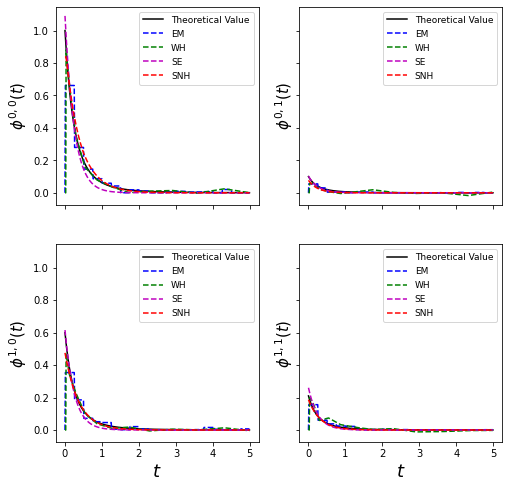

In [37]:
#Kernel plot
from tick.hawkes import HawkesEM, HawkesConditionalLaw,HawkesSumExpKern
timestamp = t
n_nodes=2



em = HawkesEM(kernel_support = 5, kernel_size=20, n_threads=1, verbose=False, tol=1e-3)
wh = HawkesConditionalLaw(n_quad=50)
learner = HawkesSumExpKern(decays = beta.reshape(-1), penalty='elasticnet',
                           elastic_net_ratio=0.8)

#fit the model
em.fit(t)
wh.fit(t)
learner.fit(t)

#get node
c_nodes = em.n_nodes

#tk
dx=0.01
tk = np.arange(0,5,dx)
y1 = np.zeros([len(tk),4])
#for p in range(4):
#    y1[:,p] = alpha[p]*((cutoff+tk)**(-beta))
    
#y1[:,2] = y1[:,2] * 0


#plot
fig, ax_list_list = plt.subplots(c_nodes,c_nodes, sharex=True,
                                         sharey=True,figsize=(8, 8))
    
p=0

for i, ax_list in enumerate(ax_list_list):
    for j, ax in enumerate(ax_list):
        y_values = y1[:,p]
        y_values=alpha[i,j]*((delta[i,j]+tk)**(-beta[i,j]))
        ax.plot(tk, y_values,'k', label="Theoretical Value" )
        y_values = em.get_kernel_values(i, j, tk)
        ax.plot(tk, y_values,'b--', label="EM")
        y_values = wh.get_kernel_values(i, j, tk)
        ax.plot(tk, y_values,'g--', label="WH")
        y_values = learner.get_kernel_values(i, j, tk)
        ax.plot(tk, y_values,'m--', label="SE")
        y_values = nnOptimalKernel(tk.reshape(1,-1),i,j).reshape(-1)
        ax.plot(tk, y_values,'r--', label="SNH")
        p=p+1
        
        # set x_label for last line
        if i == c_nodes - 1:
            ax.set_xlabel(r"$t$", fontsize=18)

        ax.set_ylabel(r"$\phi^{%g,%g}(t)$" % (i, j), fontsize=15)
        
        legend = ax.legend()
        for label in legend.get_texts():
            label.set_fontsize(9)

plt.savefig("2D_Exp_kernel.png",dpi=300)

# Error Estimation

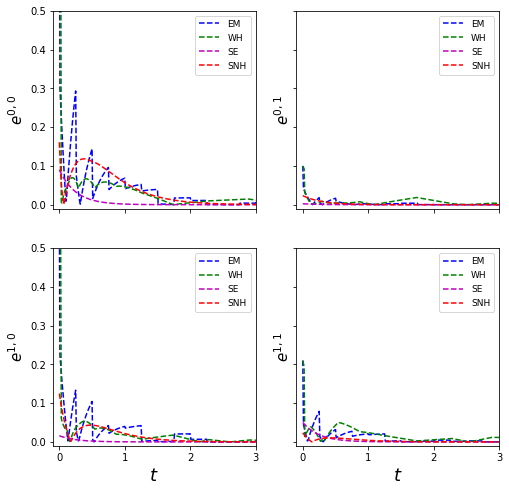

In [38]:


#L1 error

#plot
fig, ax_list_list = plt.subplots(c_nodes,c_nodes, sharex=True,
                                         sharey=True,figsize=(8, 8))

p = 0

for i, ax_list in enumerate(ax_list_list):
    for j, ax in enumerate(ax_list):
        y = alpha[i,j]*np.exp(-beta[i,j]*tk)
        em_values = em.get_kernel_values(i, j, tk)
        error1 = np.abs(y-em_values)
        ax.plot(tk, error1,'b--', label="EM")
        wh_values = wh.get_kernel_values(i, j, tk)
        error2 = np.abs(y-wh_values)
        ax.plot(tk, error2,'g--', label='WH')
        se_values = learner.get_kernel_values(i, j, tk)
        error3 = np.abs(y-se_values)
        ax.plot(tk, error3,'m--', label='SE')
        snh_values = nnOptimalKernel(tk.reshape(1,-1),i,j).reshape(-1)
        error4 = np.abs(y-snh_values)
        ax.plot(tk, error4,'r--', label="SNH")
        p = p+1
        
        # set x_label for last line
        if i == c_nodes - 1:
            ax.set_xlabel(r"$t$", fontsize=18)

        ax.set_ylabel(r"$e^{%g,%g}$" % (i, j), fontsize=15)
        ax.set_xlim([-0.1,3])
        ax.set_ylim([-0.01,0.5])
        
        legend = ax.legend()
        for label in legend.get_texts():
            label.set_fontsize(9)


plt.savefig("2D_exp_error.png",dpi=300)



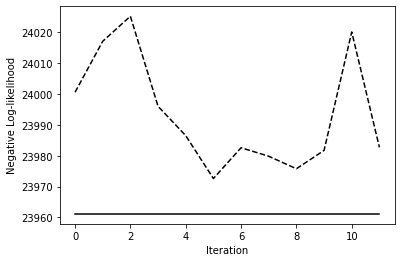

In [39]:
count=np.arange(0,len(SGD[1]),1)
plt.plot(count,SGD[1],'--',color='black')
plt.plot(count,ONLL*np.ones(len(SGD[1])),color='black')

plt.ylabel("Negative Log-likelihood")
plt.xlabel("Iteration")

plt.savefig("2D_exp_ll.png",dpi=300)

# Plotting and error estimation for random Kernels

/home/jupyter-user10/.local/lib/python3.7/site-packages/tick/hawkes/inference/hawkes_conditional_law.py:1145: RuntimeWarning: divide by zero encountered in log10
  log_abscissa_array = np.log10(abscissa_array)
/home/jupyter-user10/.local/lib/python3.7/site-packages/tick/hawkes/inference/hawkes_conditional_law.py:1145: RuntimeWarning: divide by zero encountered in log10
  log_abscissa_array = np.log10(abscissa_array)
/home/jupyter-user10/.local/lib/python3.7/site-packages/tick/hawkes/inference/hawkes_conditional_law.py:1145: RuntimeWarning: divide by zero encountered in log10
  log_abscissa_array = np.log10(abscissa_array)
/home/jupyter-user10/.local/lib/python3.7/site-packages/tick/hawkes/inference/hawkes_conditional_law.py:1145: RuntimeWarning: divide by zero encountered in log10
  log_abscissa_array = np.log10(abscissa_array)


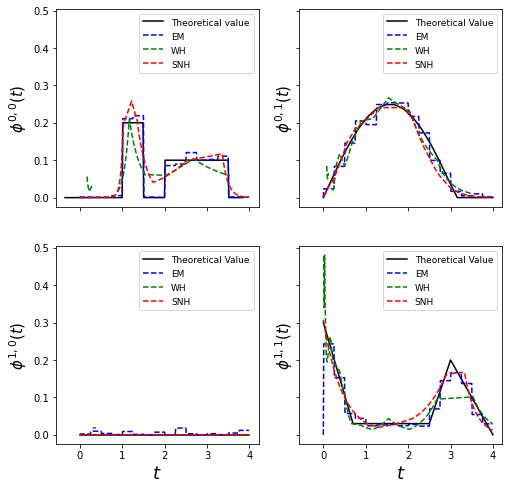

In [44]:
#to plot tick.base.time_function 
def _extended_discrete_xaxis(x_axis, n_points=100, eps=0.10):

    min_value = np.min(x_axis)
    max_value = np.max(x_axis)
    distance = max_value - min_value
    return np.linspace(min_value - eps * distance, max_value + eps * distance,
                       num=n_points)


def plot_timefunction(time_function, labels=None, n_points=300, show=True,
                      ax=None):

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    else:
        show = False

    if time_function.is_constant:
        if labels is None:
            labels = ['value = %.3g' % time_function.border_value]

        t_values = np.arange(10).astype('float')
        ax.plot(t_values, time_function.value(t_values), label= 'Theoretical value')

    else:
        if labels is None:
            interpolation_to_legend = {
                TimeFunction.InterLinear: 'Linear',
                TimeFunction.InterConstLeft: 'Constant on left',
                TimeFunction.InterConstRight: 'Constant on right'
            }

            border_to_legend = {
                TimeFunction.Border0:
                    'border zero',
                TimeFunction.BorderConstant:
                    'border constant at %.3g' % time_function.border_value,
                TimeFunction.BorderContinue:
                    'border continue',
                TimeFunction.Cyclic:
                    'cyclic'
            }

            labels = [
                'original points',
                '%s and %s' %
                (interpolation_to_legend[time_function.inter_mode],
                 border_to_legend[time_function.border_type])
            ]

        original_t = time_function.original_t
        if time_function.border_type == TimeFunction.Cyclic:
            cycle_length = original_t[-1]
            original_t = np.hstack((original_t, original_t + cycle_length,
                                    original_t + 2 * cycle_length))

        t_values = _extended_discrete_xaxis(original_t, n_points=n_points)

        #ax.plot(time_function.original_t, time_function.original_y, ls='',
                #marker='o', label=labels[0])
        ax.plot(t_values, time_function.value(t_values), 'k', label='Theoretical value')

    ax.legend()
    if show is True:
        plt.show()

    return ax.figure

#Kernel plot
from tick.hawkes import HawkesEM, HawkesConditionalLaw,HawkesSumExpKern
#from tick.plot import plot_timefunction
timestamp = t
support = 1000

em = HawkesEM(kernel_support = 5, kernel_size=20, n_threads=8, verbose=False, tol=1e-3)
wh = HawkesConditionalLaw(claw_method="log", delta_lag=0.1, min_lag=0.002,
                         max_lag=100, quad_method="log", n_quad=50,
                         min_support=0.002, max_support=support, n_threads=-1)
#learner = HawkesSumExpKern(decays = [beta], penalty='elasticnet',
                           #elastic_net_ratio=0.8)

#fit the model
em.fit(t)
wh.incremental_fit(t)
wh.compute()
#learner.fit(t)

#get node
c_nodes = em.n_nodes

#tk
dx=0.01
tk = np.arange(0,4,dx)



#plot
fig, ax_list_list = plt.subplots(c_nodes,c_nodes, sharex=True,
                                         sharey=True,figsize=(8, 8))
    
p = 0

for i, ax_list in enumerate(ax_list_list):
    for j, ax in enumerate(ax_list):
        if i == 0:
            if j == 0:
                plot_timefunction(tf1,ax=ax)
            else:
                t_value = np.linspace(0, 4, 20)
                y_value = np.maximum(0., np.sin(t_value) / 4)
                ax.plot(t_value, y_value,'k', label="Theoretical Value")
        else:
            if j == 0:
                t_value=np.array([0,1,2,3,4])
                y_value=np.array([0,0,0,0,0])
                ax.plot(t_value, y_value,'k', label="Theoretical Value" )
            else:
                t_value=np.array([0., .7, 2.5, 3., 4.])
                y_value=np.array([.3, .03, .03, .2, 0.])
                ax.plot(t_value, y_value,'k', label="Theoretical Value" )
        y_values = em.get_kernel_values(i, j, tk)
        ax.plot(tk, y_values,'b--', label="EM")
        y_values = wh.get_kernel_values(i, j, tk)
        ax.plot(tk, y_values,'g--', label="WH")
        y_values  = nnOptimalKernel(tk.reshape(1,-1),i,j).reshape(-1)
        ax.plot(tk, y_values,'r--', label="SNH")
       
        p = p+1
        
        # set x_label for last line
        if i == c_nodes - 1:
            ax.set_xlabel(r"$t$", fontsize=18)

        ax.set_ylabel(r"$\phi^{%g,%g}(t)$" % (i, j), fontsize=15)
        
        legend = ax.legend(loc='upper right')
        for label in legend.get_texts():
            label.set_fontsize(9)
plt.savefig("2D_random_kernels.png",dpi=300)

No handles with labels found to put in legend.
/home/jupyter-user10/.local/lib/python3.7/site-packages/tick/hawkes/inference/hawkes_conditional_law.py:1145: RuntimeWarning: invalid value encountered in log10
  log_abscissa_array = np.log10(abscissa_array)
/home/jupyter-user10/.local/lib/python3.7/site-packages/tick/hawkes/inference/hawkes_conditional_law.py:1145: RuntimeWarning: divide by zero encountered in log10
  log_abscissa_array = np.log10(abscissa_array)
/home/jupyter-user10/.local/lib/python3.7/site-packages/tick/hawkes/inference/hawkes_conditional_law.py:1145: RuntimeWarning: divide by zero encountered in log10
  log_abscissa_array = np.log10(abscissa_array)
/home/jupyter-user10/.local/lib/python3.7/site-packages/tick/hawkes/inference/hawkes_conditional_law.py:1145: RuntimeWarning: divide by zero encountered in log10
  log_abscissa_array = np.log10(abscissa_array)


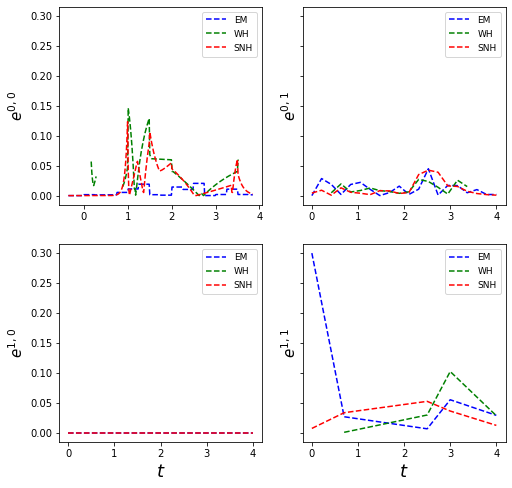

In [45]:


#to plot y_value of time function
def _extended_discrete_xaxis(x_axis, n_points=100, eps=0.10):

    min_value = np.min(x_axis)
    max_value = np.max(x_axis)
    distance = max_value - min_value
    return np.linspace(min_value - eps * distance, max_value + eps * distance,
                       num=n_points)


def plot_timefunction(time_function, labels=None, n_points=300, show=True,
                      ax=None):

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    else:
        show = False

    if time_function.is_constant:
        if labels is None:
            labels = ['value = %.3g' % time_function.border_value]

        t_values = np.arange(10).astype('float')
        ax.plot(t_values, time_function.value(t_values), label= 'Theoretical value')

    else:
        if labels is None:
            interpolation_to_legend = {
                TimeFunction.InterLinear: 'Linear',
                TimeFunction.InterConstLeft: 'Constant on left',
                TimeFunction.InterConstRight: 'Constant on right'
            }

            border_to_legend = {
                TimeFunction.Border0:
                    'border zero',
                TimeFunction.BorderConstant:
                    'border constant at %.3g' % time_function.border_value,
                TimeFunction.BorderContinue:
                    'border continue',
                TimeFunction.Cyclic:
                    'cyclic'
            }

            labels = [
                'original points',
                '%s and %s' %
                (interpolation_to_legend[time_function.inter_mode],
                 border_to_legend[time_function.border_type])
            ]

        original_t = time_function.original_t
        if time_function.border_type == TimeFunction.Cyclic:
            cycle_length = original_t[-1]
            original_t = np.hstack((original_t, original_t + cycle_length,
                                    original_t + 2 * cycle_length))

        t_values = _extended_discrete_xaxis(original_t, n_points=n_points)

        #ax.plot(time_function.original_t, time_function.original_y, ls='',
                #marker='o', label=labels[0])
        #ax.plot(t_values, time_function.value(t_values), 'k', label='Theoretical value')

    ax.legend()
    if show is True:
        plt.show()

    return t_values, time_function.value(t_values)

#L1 error

#plot
fig, ax_list_list = plt.subplots(c_nodes,c_nodes, sharex=False,
                                         sharey=True,figsize=(8, 8))

p = 0

for i, ax_list in enumerate(ax_list_list):
    for j, ax in enumerate(ax_list):
        if i == 0:
            if j == 0:
                #t_value = np.array([0, 1, 1.5, 2., 3.5])
                temp = plot_timefunction(tf1,ax=ax)
                t_value = temp[0]
                y_value = temp[1]
            else:
                t_value = np.linspace(0, 4, 20)
                y_value = np.maximum(0., np.sin(t_values2) / 4)
        else:
            if j == 0:
                t_value=np.array([0,1,2,3,4])
                y_value=np.array([0,0,0,0,0])
            else:
                t_value=np.array([0., .7, 2.5, 3., 4.])
                y_value=np.array([.3, .03, .03, .2, 0.])
        em_values = em.get_kernel_values(i, j, t_value)
        error1 = np.abs(y_value-em_values)
        ax.plot(t_value, error1,'b--', label="EM")
        wh_values = wh.get_kernel_values(i, j, t_value)
        error2 = np.abs(y_value-wh_values)
        ax.plot(t_value, error2,'g--', label='WH')
       
        y2 = (nnOptimalKernel(t_value.reshape(1,-1),i,j)).reshape(-1)
        error4 = np.abs(y_value-y2)
        ax.plot(t_value, error4,'r--', label="SNH")
        p = p+1
        
        # set x_label for last line
        if i == c_nodes - 1:
            ax.set_xlabel(r"$t$", fontsize=18)

        ax.set_ylabel(r"$e^{%g,%g}$" % (i, j), fontsize=15)
        
        
        legend = ax.legend()
        for label in legend.get_texts():
            label.set_fontsize(9)
#fig.tight_layout()


plt.savefig("2D_random_error.png",dpi=300)